In [1]:
print(" Installing time series libraries...")

!pip install -q prophet
!pip install -q statsmodels
!pip install -q plotly
!pip install -q tensorflow

print(" All libraries installed!\n")

 Installing time series libraries...
 All libraries installed!



In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

# Time series specific
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from prophet import Prophet

# Deep learning
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

# Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from math import sqrt

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)
pd.set_option('display.max_columns', None)

print(" All libraries imported successfully!")
print(f"TensorFlow version: {tf.__version__}")


 All libraries imported successfully!
TensorFlow version: 2.19.0


In [3]:
print("="*60)
print("GENERATING TIME SERIES DATA")
print("="*60)

# Generate realistic sales data
np.random.seed(42)

# Date range: 3 years of daily data
date_range = pd.date_range(start='2021-01-01', end='2023-12-31', freq='D')
n_days = len(date_range)

print(f"\n Generating {n_days} days of sales data...")

# Base trend (increasing over time)
trend = np.linspace(100, 200, n_days)

# Seasonal component (yearly seasonality)
seasonality = 50 * np.sin(2 * np.pi * np.arange(n_days) / 365.25)

# Weekly pattern (higher sales on weekends)
weekly = 20 * np.sin(2 * np.pi * np.arange(n_days) / 7)

# Random noise
noise = np.random.normal(0, 10, n_days)

# Combine all components
sales = trend + seasonality + weekly + noise

# Create DataFrame
df = pd.DataFrame({
    'date': date_range,
    'sales': sales
})

# Add additional features
df['day_of_week'] = df['date'].dt.dayofweek
df['day_name'] = df['date'].dt.day_name()
df['month'] = df['date'].dt.month
df['month_name'] = df['date'].dt.month_name()
df['quarter'] = df['date'].dt.quarter
df['year'] = df['date'].dt.year
df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)

print(f" Time series data generated!")
print(f"\n Dataset shape: {df.shape}")
print(f"Date range: {df['date'].min()} to {df['date'].max()}")
print(f"\nFirst 5 rows:")
print(df.head())



GENERATING TIME SERIES DATA

 Generating 1095 days of sales data...
 Time series data generated!

 Dataset shape: (1095, 9)
Date range: 2021-01-01 00:00:00 to 2023-12-31 00:00:00

First 5 rows:
        date       sales  day_of_week  day_name  month month_name  quarter  \
0 2021-01-01  104.967142            4    Friday      1    January        1   
1 2021-01-02  115.205473            5  Saturday      1    January        1   
2 2021-01-03  127.878162            6    Sunday      1    January        1   
3 2021-01-04  126.761415            0    Monday      1    January        1   
4 2021-01-05   92.784193            1   Tuesday      1    January        1   

   year  is_weekend  
0  2021           0  
1  2021           1  
2  2021           1  
3  2021           0  
4  2021           0  



EXPLORATORY DATA ANALYSIS

 Sales Statistics:
count    1095.000000
mean      150.362164
std        43.147975
min        37.934393
25%       119.860029
50%       149.508967
75%       182.017315
max       258.632853
Name: sales, dtype: float64


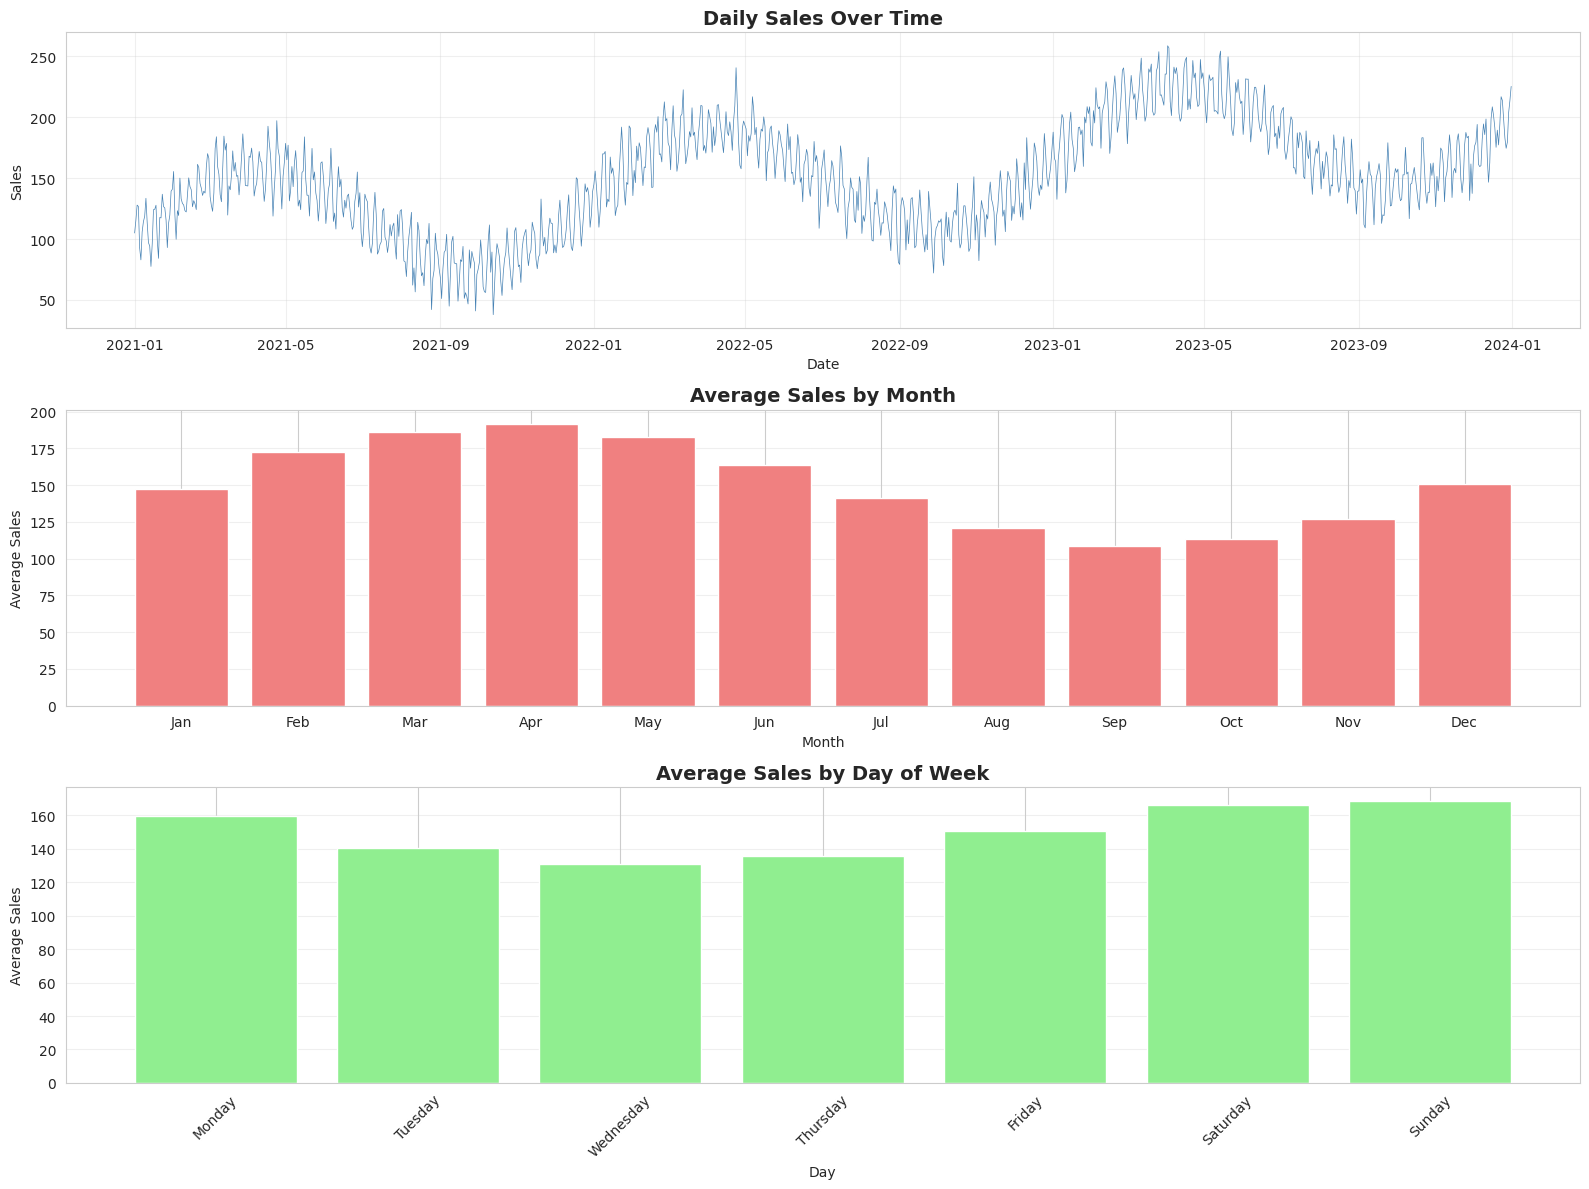


 EDA completed!


In [4]:
print("\n" + "="*60)
print("EXPLORATORY DATA ANALYSIS")
print("="*60)

# Basic statistics
print("\n Sales Statistics:")
print(df['sales'].describe())

# Visualize the time series
fig, axes = plt.subplots(3, 1, figsize=(16, 12))

# 1. Overall time series
axes[0].plot(df['date'], df['sales'], linewidth=0.5, color='steelblue')
axes[0].set_title('Daily Sales Over Time', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Sales')
axes[0].grid(True, alpha=0.3)

# 2. Monthly average
monthly_avg = df.groupby('month')['sales'].mean()
axes[1].bar(monthly_avg.index, monthly_avg.values, color='lightcoral')
axes[1].set_title('Average Sales by Month', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Month')
axes[1].set_ylabel('Average Sales')
axes[1].set_xticks(range(1, 13))
axes[1].set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                          'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
axes[1].grid(True, alpha=0.3, axis='y')

# 3. Day of week pattern
weekly_avg = df.groupby('day_name')['sales'].mean().reindex(
    ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
)
axes[2].bar(weekly_avg.index, weekly_avg.values, color='lightgreen')
axes[2].set_title('Average Sales by Day of Week', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Day')
axes[2].set_ylabel('Average Sales')
axes[2].tick_params(axis='x', rotation=45)
axes[2].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\n EDA completed!")



TIME SERIES DECOMPOSITION


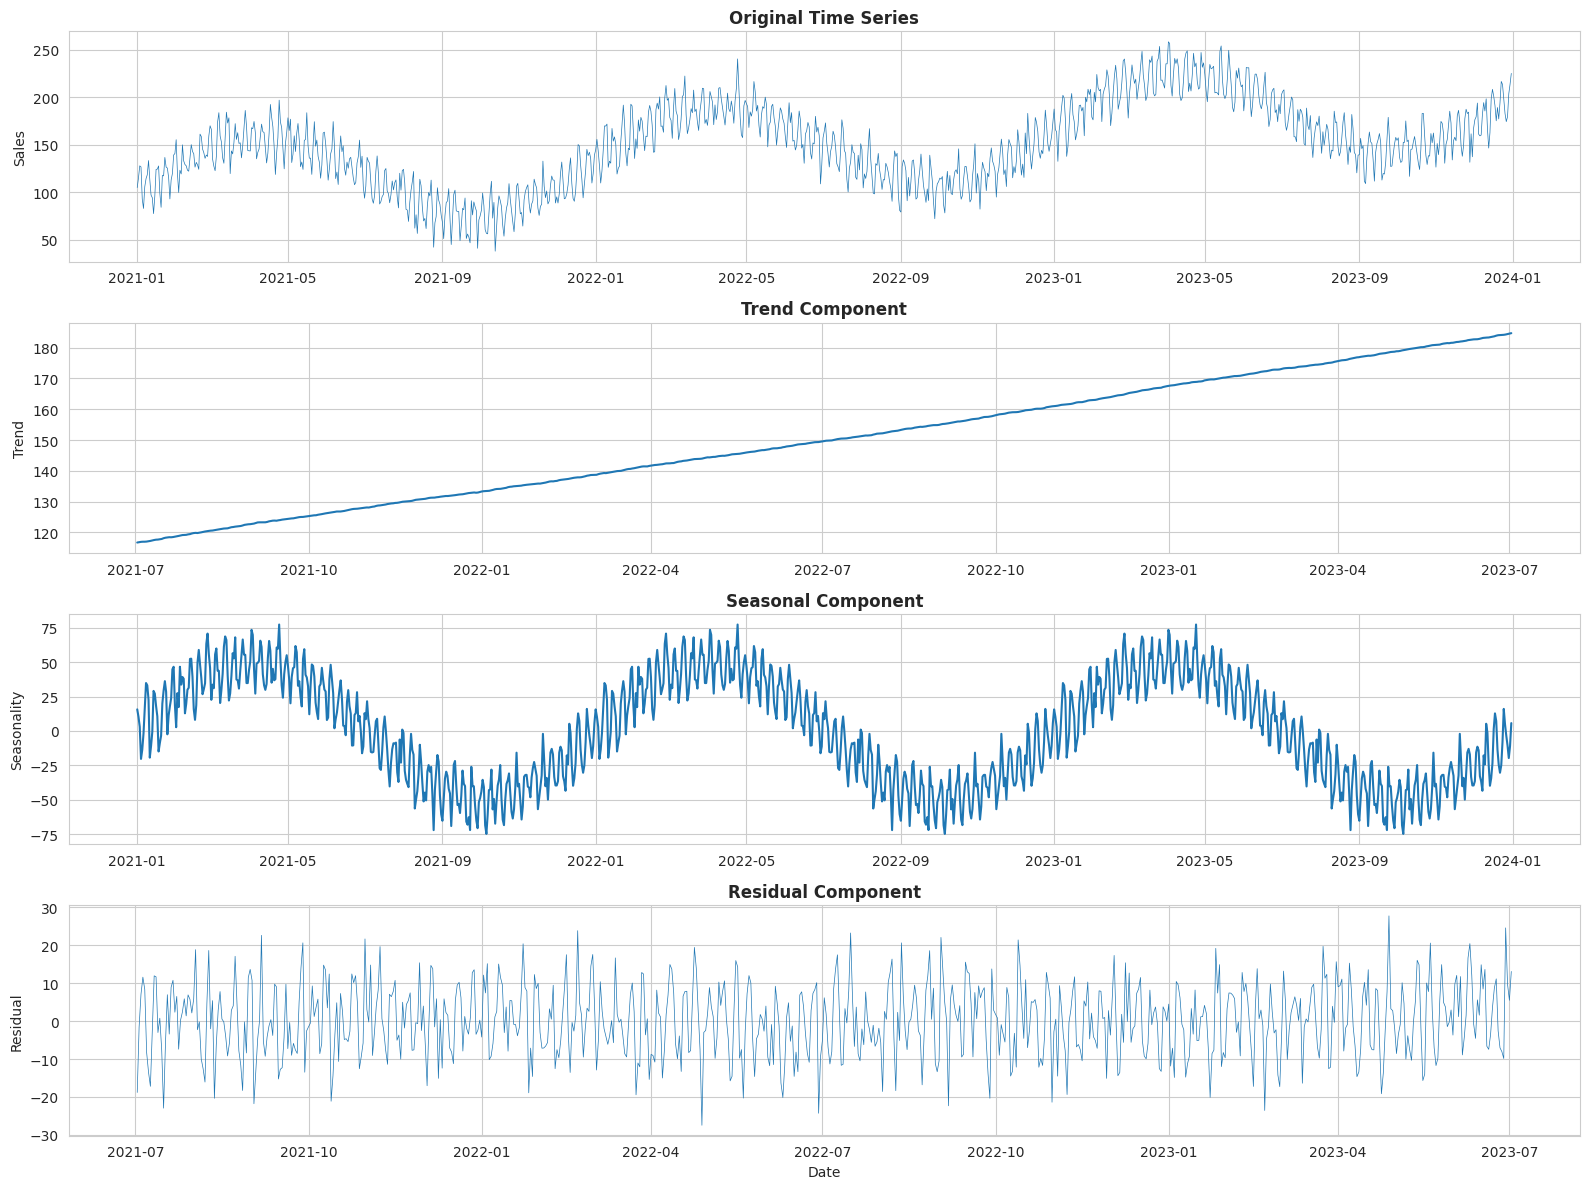

 Decomposition completed!


In [5]:
print("\n" + "="*60)
print("TIME SERIES DECOMPOSITION")
print("="*60)

# Decompose the time series
decomposition = seasonal_decompose(df.set_index('date')['sales'],
                                   model='additive',
                                   period=365)

# Plot decomposition
fig, axes = plt.subplots(4, 1, figsize=(16, 12))

# Original
axes[0].plot(df['date'], df['sales'], linewidth=0.5)
axes[0].set_title('Original Time Series', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Sales')

# Trend
axes[1].plot(df['date'], decomposition.trend)
axes[1].set_title('Trend Component', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Trend')

# Seasonality
axes[2].plot(df['date'], decomposition.seasonal)
axes[2].set_title('Seasonal Component', fontsize=12, fontweight='bold')
axes[2].set_ylabel('Seasonality')

# Residual
axes[3].plot(df['date'], decomposition.resid, linewidth=0.5)
axes[3].set_title('Residual Component', fontsize=12, fontweight='bold')
axes[3].set_ylabel('Residual')
axes[3].set_xlabel('Date')

plt.tight_layout()
plt.show()

print(" Decomposition completed!")



In [6]:
print("\n" + "="*60)
print("STATIONARITY TEST (ADF Test)")
print("="*60)

def adf_test(series):
    """Perform Augmented Dickey-Fuller test"""
    result = adfuller(series.dropna())

    print(f'\nADF Statistic: {result[0]:.4f}')
    print(f'p-value: {result[1]:.4f}')
    print(f'Critical Values:')
    for key, value in result[4].items():
        print(f'   {key}: {value:.3f}')

    if result[1] <= 0.05:
        print("\n Series is STATIONARY (reject null hypothesis)")
    else:
        print("\n Series is NON-STATIONARY (fail to reject null hypothesis)")

    return result[1]

# Test original series
print("Testing original series:")
p_value = adf_test(df['sales'])

# If non-stationary, difference it
if p_value > 0.05:
    print("\n Differencing the series...")
    df['sales_diff'] = df['sales'].diff()
    print("\nTesting differenced series:")
    adf_test(df['sales_diff'])



STATIONARITY TEST (ADF Test)
Testing original series:

ADF Statistic: -1.4526
p-value: 0.5568
Critical Values:
   1%: -3.436
   5%: -2.864
   10%: -2.568

 Series is NON-STATIONARY (fail to reject null hypothesis)

 Differencing the series...

Testing differenced series:

ADF Statistic: -4.5595
p-value: 0.0002
Critical Values:
   1%: -3.436
   5%: -2.864
   10%: -2.568

 Series is STATIONARY (reject null hypothesis)



TRAIN-TEST SPLIT

 Data split:
   Training set: 876 days (2021-01-01 00:00:00 to 2023-05-26 00:00:00)
   Test set: 219 days (2023-05-27 00:00:00 to 2023-12-31 00:00:00)


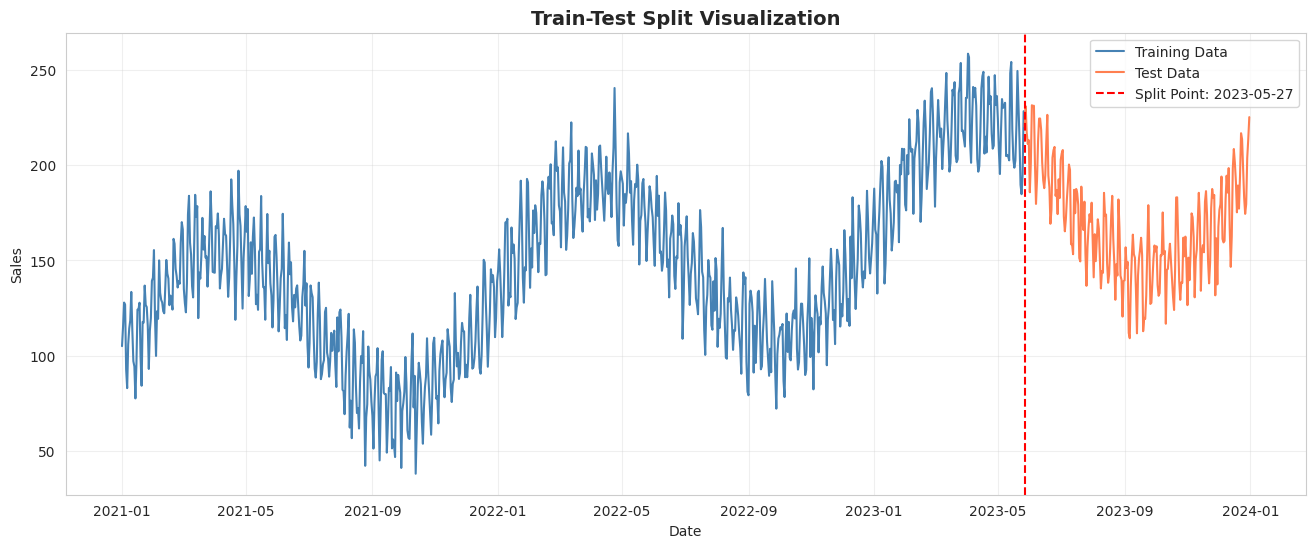

In [7]:
print("\n" + "="*60)
print("TRAIN-TEST SPLIT")
print("="*60)

# Split data: 80% train, 20% test
train_size = int(len(df) * 0.8)
train_df = df[:train_size].copy()
test_df = df[train_size:].copy()

print(f"\n Data split:")
print(f"   Training set: {len(train_df)} days ({train_df['date'].min()} to {train_df['date'].max()})")
print(f"   Test set: {len(test_df)} days ({test_df['date'].min()} to {test_df['date'].max()})")

# Visualize split
plt.figure(figsize=(16, 6))
plt.plot(train_df['date'], train_df['sales'], label='Training Data', color='steelblue')
plt.plot(test_df['date'], test_df['sales'], label='Test Data', color='coral')
plt.axvline(x=test_df['date'].iloc[0], color='red', linestyle='--',
            label=f'Split Point: {test_df["date"].iloc[0].date()}')
plt.title('Train-Test Split Visualization', fontsize=14, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()



MODEL 1: ARIMA FORECASTING

 Training ARIMA model...
   (This may take 2-3 minutes...)
 ARIMA model trained!

Model Summary:
                               SARIMAX Results                                
Dep. Variable:                  sales   No. Observations:                  876
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -3461.784
Date:                Sun, 23 Nov 2025   AIC                           6935.567
Time:                        03:51:59   BIC                           6964.213
Sample:                             0   HQIC                          6946.525
                                - 876                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5172      0.032    -16.315      0.000      -0.579      -0.455
ar.L2

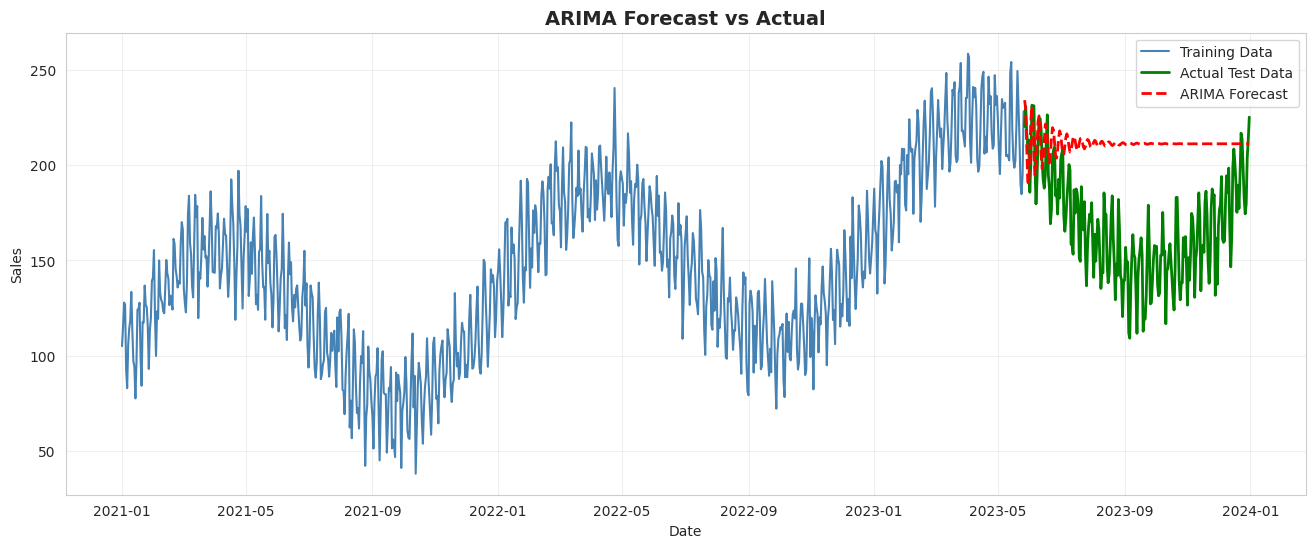

In [8]:
print("\n" + "="*60)
print("MODEL 1: ARIMA FORECASTING")
print("="*60)

print("\n Training ARIMA model...")
print("   (This may take 2-3 minutes...)")

# Fit ARIMA model
# Using (5,1,0) as order - you can tune this
arima_model = ARIMA(train_df['sales'], order=(5, 1, 0))
arima_fitted = arima_model.fit()

print(" ARIMA model trained!")
print(f"\nModel Summary:")
print(arima_fitted.summary())

# Make predictions
print("\n Generating ARIMA forecasts...")
arima_forecast = arima_fitted.forecast(steps=len(test_df))

# Calculate metrics
arima_rmse = sqrt(mean_squared_error(test_df['sales'], arima_forecast))
arima_mae = mean_absolute_error(test_df['sales'], arima_forecast)
arima_r2 = r2_score(test_df['sales'], arima_forecast)

print(f"\n ARIMA Model Performance:")
print(f"   RMSE: {arima_rmse:.2f}")
print(f"   MAE: {arima_mae:.2f}")
print(f"   R² Score: {arima_r2:.4f}")

# Visualize ARIMA results
plt.figure(figsize=(16, 6))
plt.plot(train_df['date'], train_df['sales'], label='Training Data', color='steelblue')
plt.plot(test_df['date'], test_df['sales'], label='Actual Test Data', color='green', linewidth=2)
plt.plot(test_df['date'], arima_forecast, label='ARIMA Forecast',
         color='red', linestyle='--', linewidth=2)
plt.title('ARIMA Forecast vs Actual', fontsize=14, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()



MODEL 2: FACEBOOK PROPHET

 Training Prophet model...
Found existing installation: prophet 1.1.7
Uninstalling prophet-1.1.7:
  Successfully uninstalled prophet-1.1.7
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 120.0 MB/s eta 0:00:00
 Prophet model trained!

 Generating Prophet forecasts...

 Prophet Model Performance:
   RMSE: 9.85
   MAE: 7.80
   R² Score: 0.8699


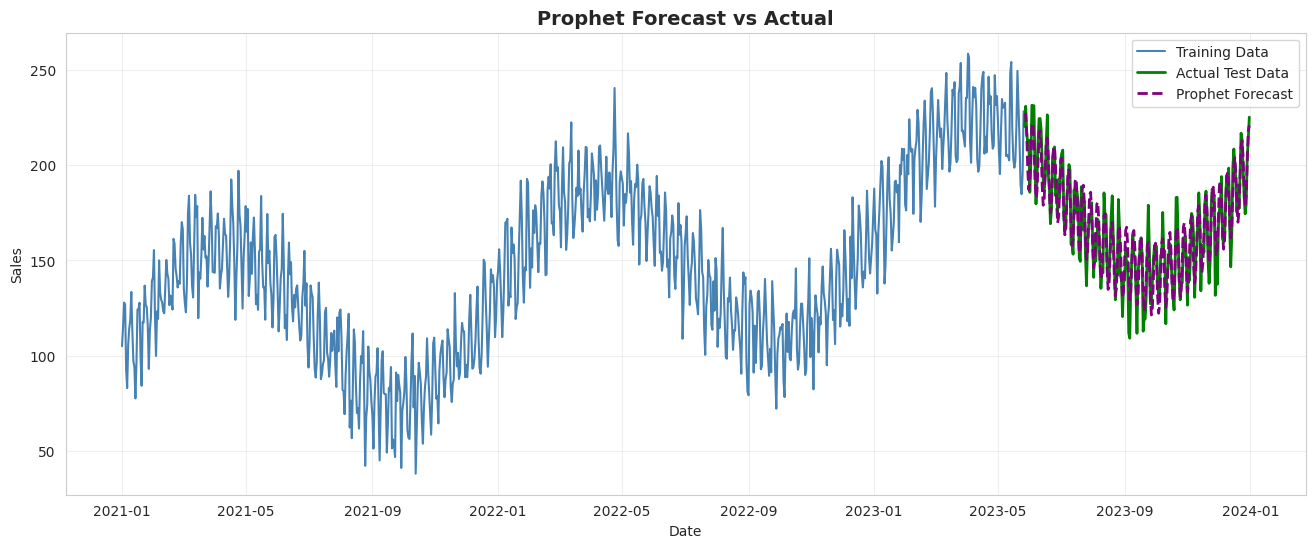

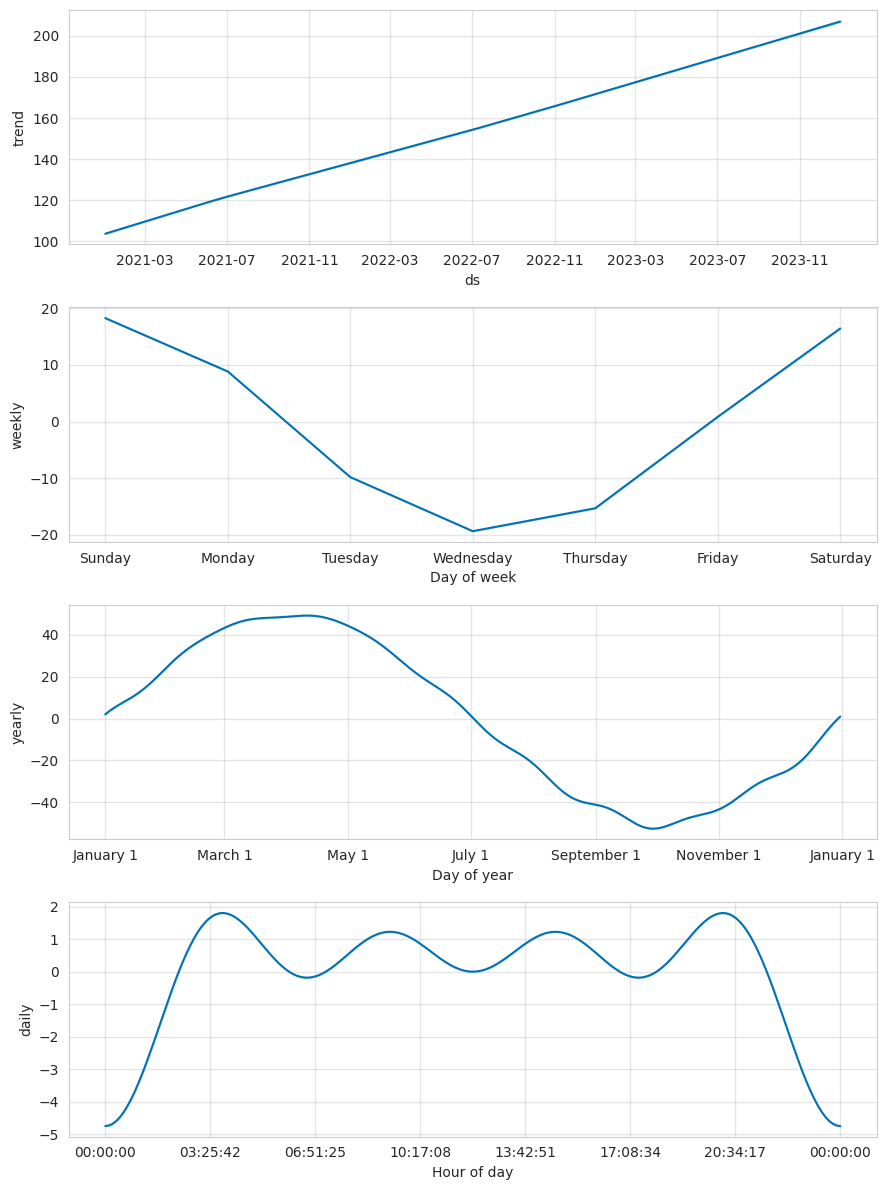

In [11]:
print("\n" + "="*60)
print("MODEL 2: FACEBOOK PROPHET")
print("="*60)

print("\n Training Prophet model...")

# Prepare data for Prophet (needs 'ds' and 'y' columns)
prophet_train = train_df[['date', 'sales']].copy()
prophet_train.columns = ['ds', 'y']

prophet_test = test_df[['date', 'sales']].copy()
prophet_test.columns = ['ds', 'y']

# Uninstall and reinstall prophet and pystan to fix 'stan_backend' error
!pip uninstall -y prophet pystan
!pip install -q prophet

# Initialize and fit Prophet
prophet_model = Prophet(
    daily_seasonality=True,
    weekly_seasonality=True,
    yearly_seasonality=True
)
prophet_model.fit(prophet_train)

print(" Prophet model trained!")

# Make predictions
print("\n Generating Prophet forecasts...")
future = prophet_model.make_future_dataframe(periods=len(test_df))
prophet_forecast = prophet_model.predict(future)

# Extract test predictions
prophet_predictions = prophet_forecast.iloc[-len(test_df):]['yhat'].values

# Calculate metrics
prophet_rmse = sqrt(mean_squared_error(test_df['sales'], prophet_predictions))
prophet_mae = mean_absolute_error(test_df['sales'], prophet_predictions)
prophet_r2 = r2_score(test_df['sales'], prophet_predictions)

print(f"\n Prophet Model Performance:")
print(f"   RMSE: {prophet_rmse:.2f}")
print(f"   MAE: {prophet_mae:.2f}")
print(f"   R² Score: {prophet_r2:.4f}")

# Visualize Prophet results
plt.figure(figsize=(16, 6))
plt.plot(train_df['date'], train_df['sales'], label='Training Data', color='steelblue')
plt.plot(test_df['date'], test_df['sales'], label='Actual Test Data', color='green', linewidth=2)
plt.plot(test_df['date'], prophet_predictions, label='Prophet Forecast',
         color='purple', linestyle='--', linewidth=2)
plt.title('Prophet Forecast vs Actual', fontsize=14, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Plot Prophet components
fig = prophet_model.plot_components(prophet_forecast)
plt.show()


MODEL 3: LSTM (DEEP LEARNING)

 Preparing data for LSTM...
 Data prepared!
   Using past 30 days to predict next day
   Total training samples: 27

 Building LSTM model...
 LSTM model built!

Model Architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 30, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)


 Training LSTM model...
   (This will take 3-5 minutes...)
 LSTM model trained!

 Generating LSTM forecasts...

 LSTM Model Performance:
   RMSE: 63.65
   MAE: 53.83
   R² Score: -4.4382


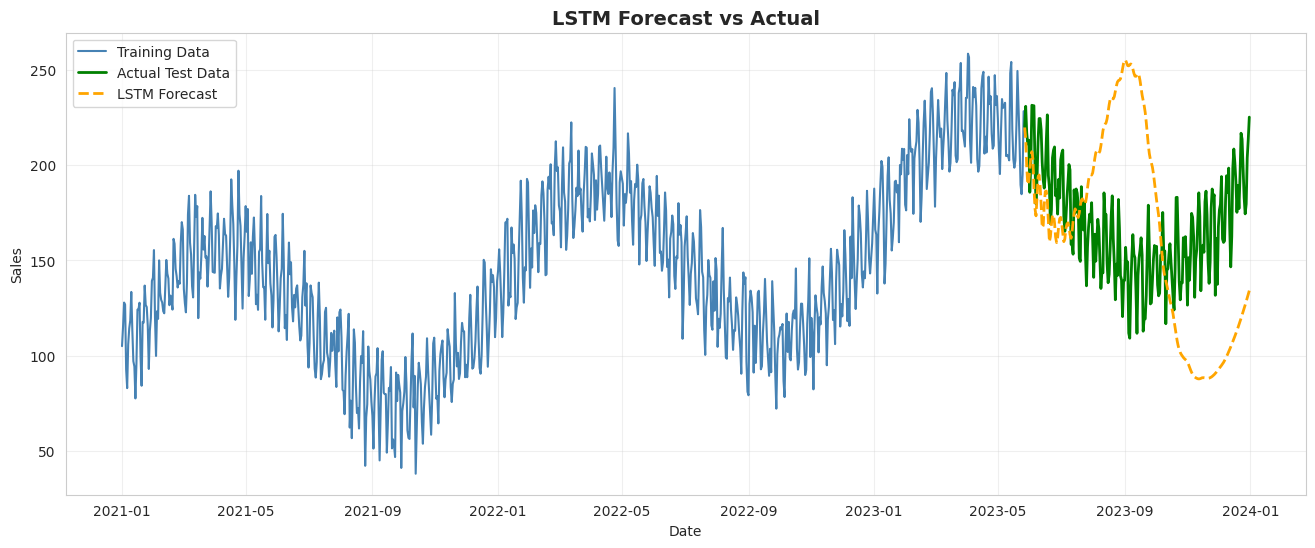

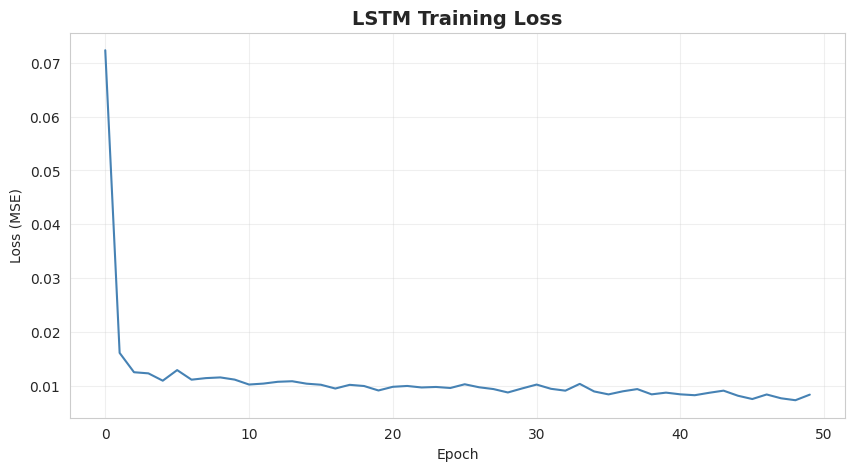

In [12]:
print("\n" + "="*60)
print("MODEL 3: LSTM (DEEP LEARNING)")
print("="*60)

print("\n Preparing data for LSTM...")

# Scale the data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

train_scaled = scaler.fit_transform(train_df[['sales']])
test_scaled = scaler.transform(test_df[['sales']])

# Create sequences
n_input = 30  # Use past 30 days to predict next day
n_features = 1

generator = TimeseriesGenerator(
    train_scaled,
    train_scaled,
    length=n_input,
    batch_size=32
)

print(f" Data prepared!")
print(f"   Using past {n_input} days to predict next day")
print(f"   Total training samples: {len(generator)}")

# Build LSTM model
print("\n Building LSTM model...")

lstm_model = Sequential([
    LSTM(50, activation='relu', return_sequences=True, input_shape=(n_input, n_features)),
    Dropout(0.2),
    LSTM(50, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

lstm_model.compile(optimizer='adam', loss='mse')

print(" LSTM model built!")
print("\nModel Architecture:")
lstm_model.summary()

# Train LSTM
print("\n Training LSTM model...")
print("   (This will take 3-5 minutes...)")

history = lstm_model.fit(
    generator,
    epochs=50,
    verbose=0
)

print(" LSTM model trained!")

# Make predictions
print("\n Generating LSTM forecasts...")

# Prepare test data
test_input = train_scaled[-n_input:]
lstm_predictions = []

for i in range(len(test_df)):
    pred = lstm_model.predict(test_input.reshape(1, n_input, n_features), verbose=0)
    lstm_predictions.append(pred[0, 0])
    test_input = np.append(test_input[1:], pred)

# Inverse transform predictions
lstm_predictions = scaler.inverse_transform(np.array(lstm_predictions).reshape(-1, 1))
lstm_predictions = lstm_predictions.flatten()

# Calculate metrics
lstm_rmse = sqrt(mean_squared_error(test_df['sales'], lstm_predictions))
lstm_mae = mean_absolute_error(test_df['sales'], lstm_predictions)
lstm_r2 = r2_score(test_df['sales'], lstm_predictions)

print(f"\n LSTM Model Performance:")
print(f"   RMSE: {lstm_rmse:.2f}")
print(f"   MAE: {lstm_mae:.2f}")
print(f"   R² Score: {lstm_r2:.4f}")

# Visualize LSTM results
plt.figure(figsize=(16, 6))
plt.plot(train_df['date'], train_df['sales'], label='Training Data', color='steelblue')
plt.plot(test_df['date'], test_df['sales'], label='Actual Test Data', color='green', linewidth=2)
plt.plot(test_df['date'], lstm_predictions, label='LSTM Forecast',
         color='orange', linestyle='--', linewidth=2)
plt.title('LSTM Forecast vs Actual', fontsize=14, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Plot training loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], color='steelblue')
plt.title('LSTM Training Loss', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.grid(True, alpha=0.3)
plt.show()



MODEL COMPARISON

 Model Performance Comparison:
  Model      RMSE       MAE  R² Score
  ARIMA 51.324198 44.945012 -2.535767
Prophet  9.845003  7.801361  0.869902
   LSTM 63.651258 53.831059 -4.438176


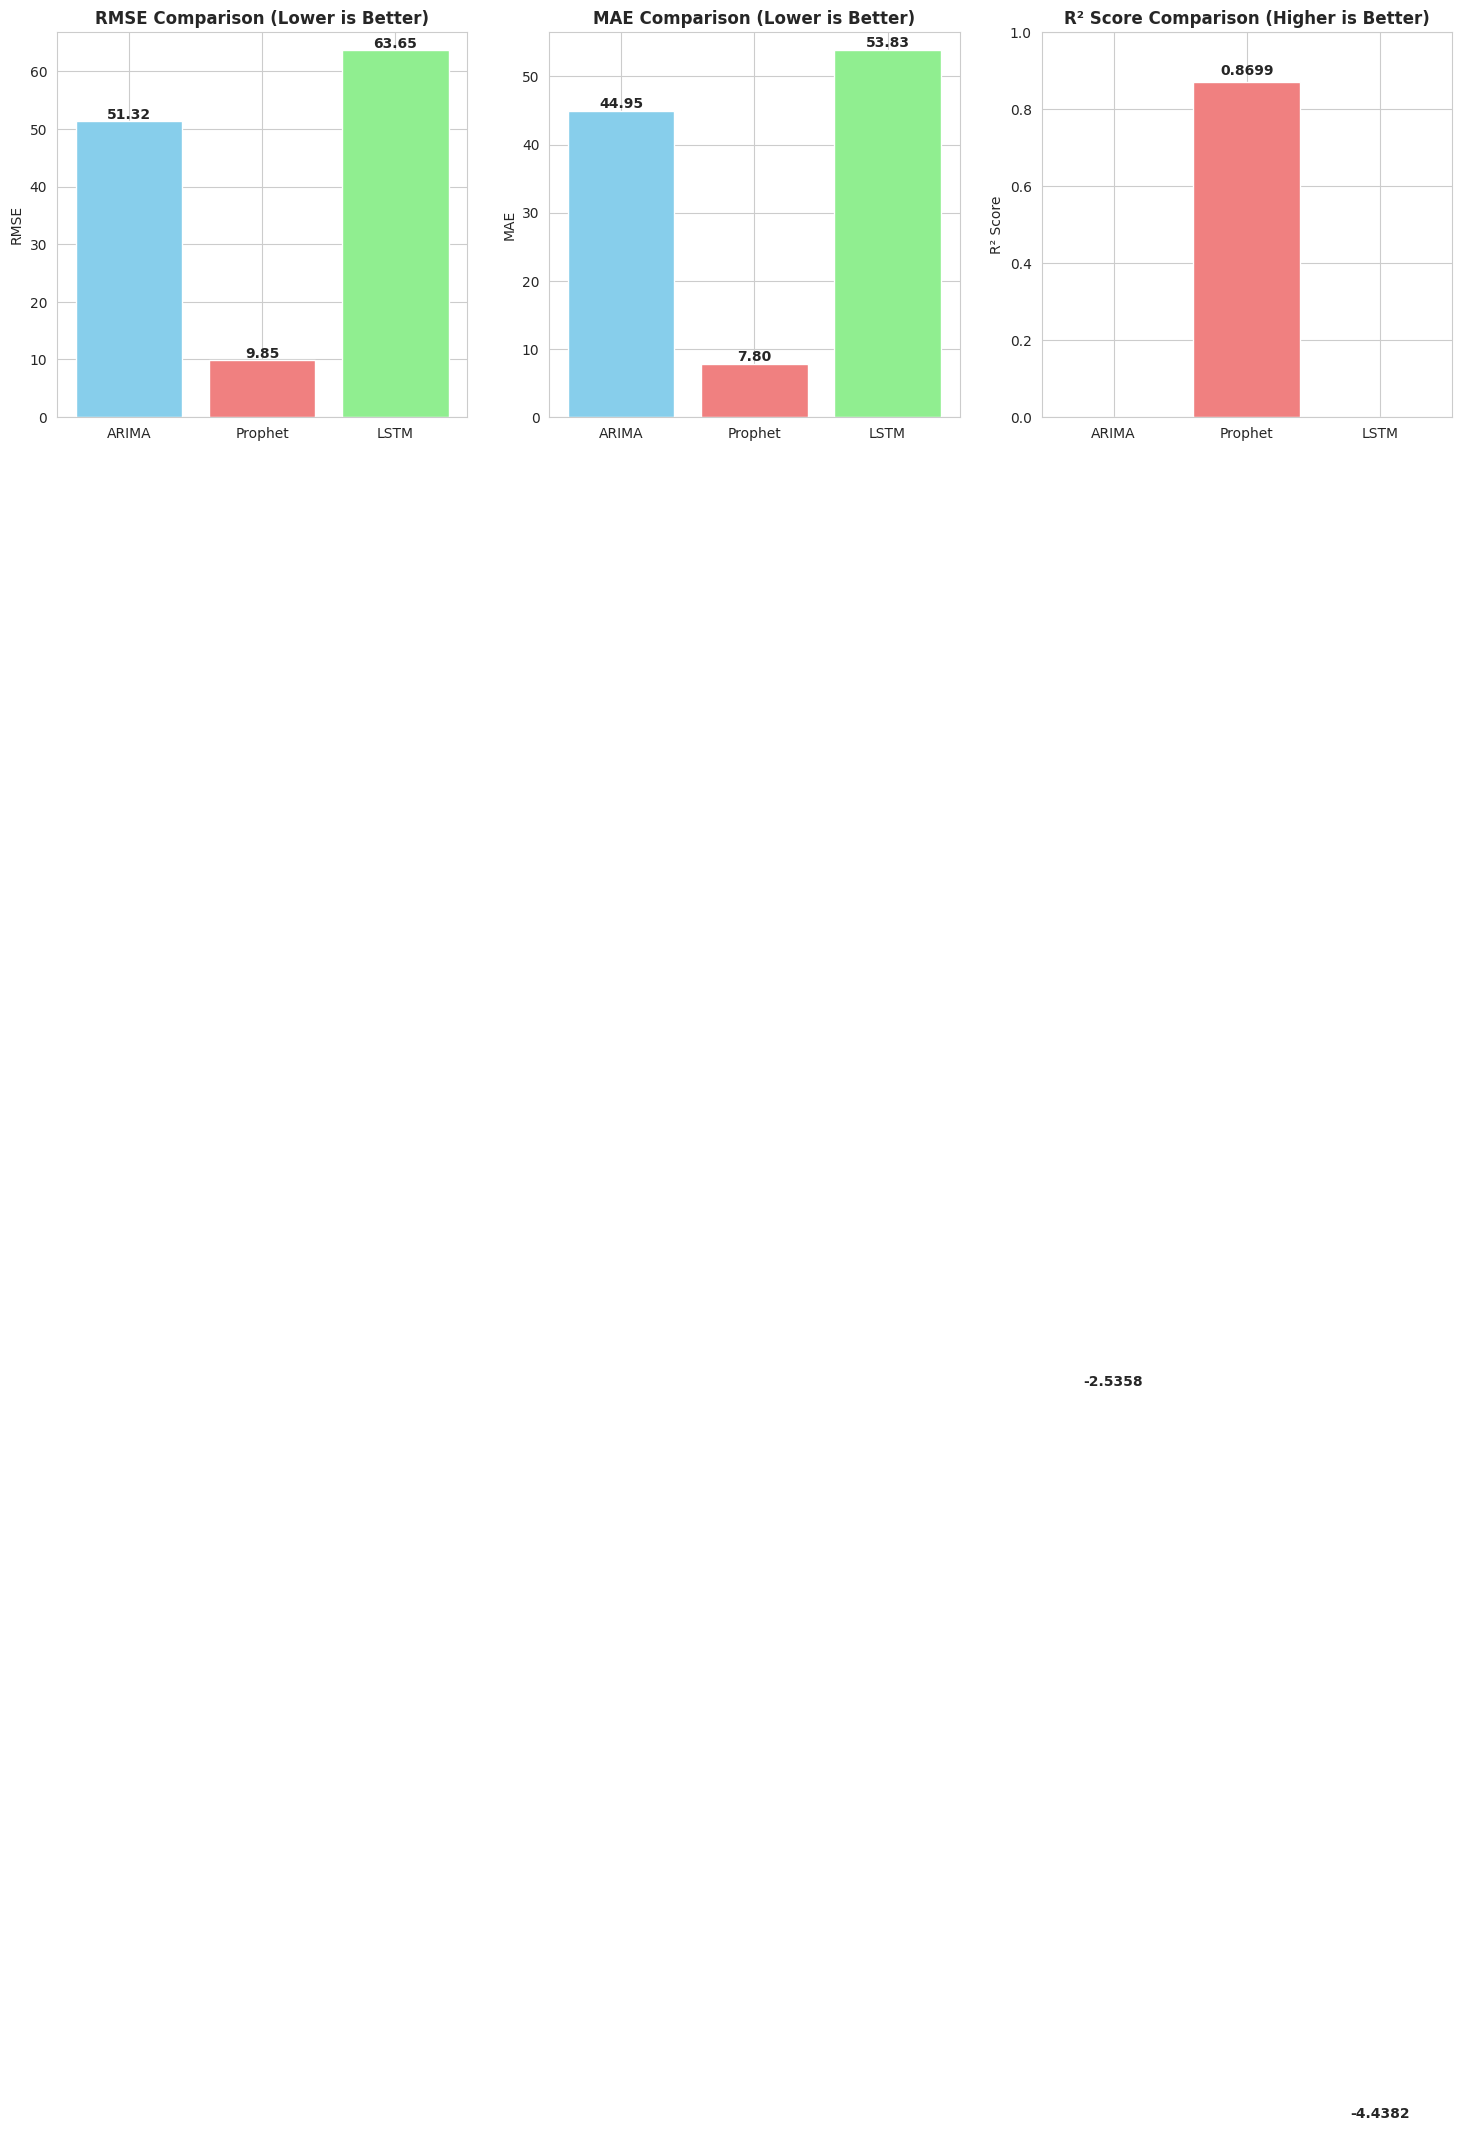


 BEST MODEL: Prophet
   RMSE: 9.85
   MAE: 7.80
   R²: 0.8699


In [14]:
print("\n" + "="*60)
print("MODEL COMPARISON")
print("="*60)

# Create comparison dataframe
comparison_df = pd.DataFrame({
    'Model': ['ARIMA', 'Prophet', 'LSTM'],
    'RMSE': [arima_rmse, prophet_rmse, lstm_rmse],
    'MAE': [arima_mae, prophet_mae, lstm_mae],
    'R² Score': [arima_r2, prophet_r2, lstm_r2]
})

print("\n Model Performance Comparison:")
print(comparison_df.to_string(index=False))

# Visualize comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# RMSE comparison
axes[0].bar(comparison_df['Model'], comparison_df['RMSE'], color=['skyblue', 'lightcoral', 'lightgreen'])
axes[0].set_title('RMSE Comparison (Lower is Better)', fontweight='bold')
axes[0].set_ylabel('RMSE')
for i, v in enumerate(comparison_df['RMSE']):
    axes[0].text(i, v + 0.5, f'{v:.2f}', ha='center', fontweight='bold')

# MAE comparison
axes[1].bar(comparison_df['Model'], comparison_df['MAE'], color=['skyblue', 'lightcoral', 'lightgreen'])
axes[1].set_title('MAE Comparison (Lower is Better)', fontweight='bold')
axes[1].set_ylabel('MAE')
for i, v in enumerate(comparison_df['MAE']):
    axes[1].text(i, v + 0.5, f'{v:.2f}', ha='center', fontweight='bold')

# R² comparison
axes[2].bar(comparison_df['Model'], comparison_df['R² Score'], color=['skyblue', 'lightcoral', 'lightgreen'])
axes[2].set_title('R² Score Comparison (Higher is Better)', fontweight='bold')
axes[2].set_ylabel('R² Score')
axes[2].set_ylim(0, 1)
for i, v in enumerate(comparison_df['R² Score']):
    axes[2].text(i, v + 0.02, f'{v:.4f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

# Best model
best_model_idx = comparison_df['RMSE'].idxmin()
best_model = comparison_df.iloc[best_model_idx]['Model']

print(f"\n BEST MODEL: {best_model}")
print(f"   RMSE: {comparison_df.iloc[best_model_idx]['RMSE']:.2f}")
print(f"   MAE: {comparison_df.iloc[best_model_idx]['MAE']:.2f}")
print(f"   R²: {comparison_df.iloc[best_model_idx]['R² Score']:.4f}")



COMBINED FORECAST VISUALIZATION


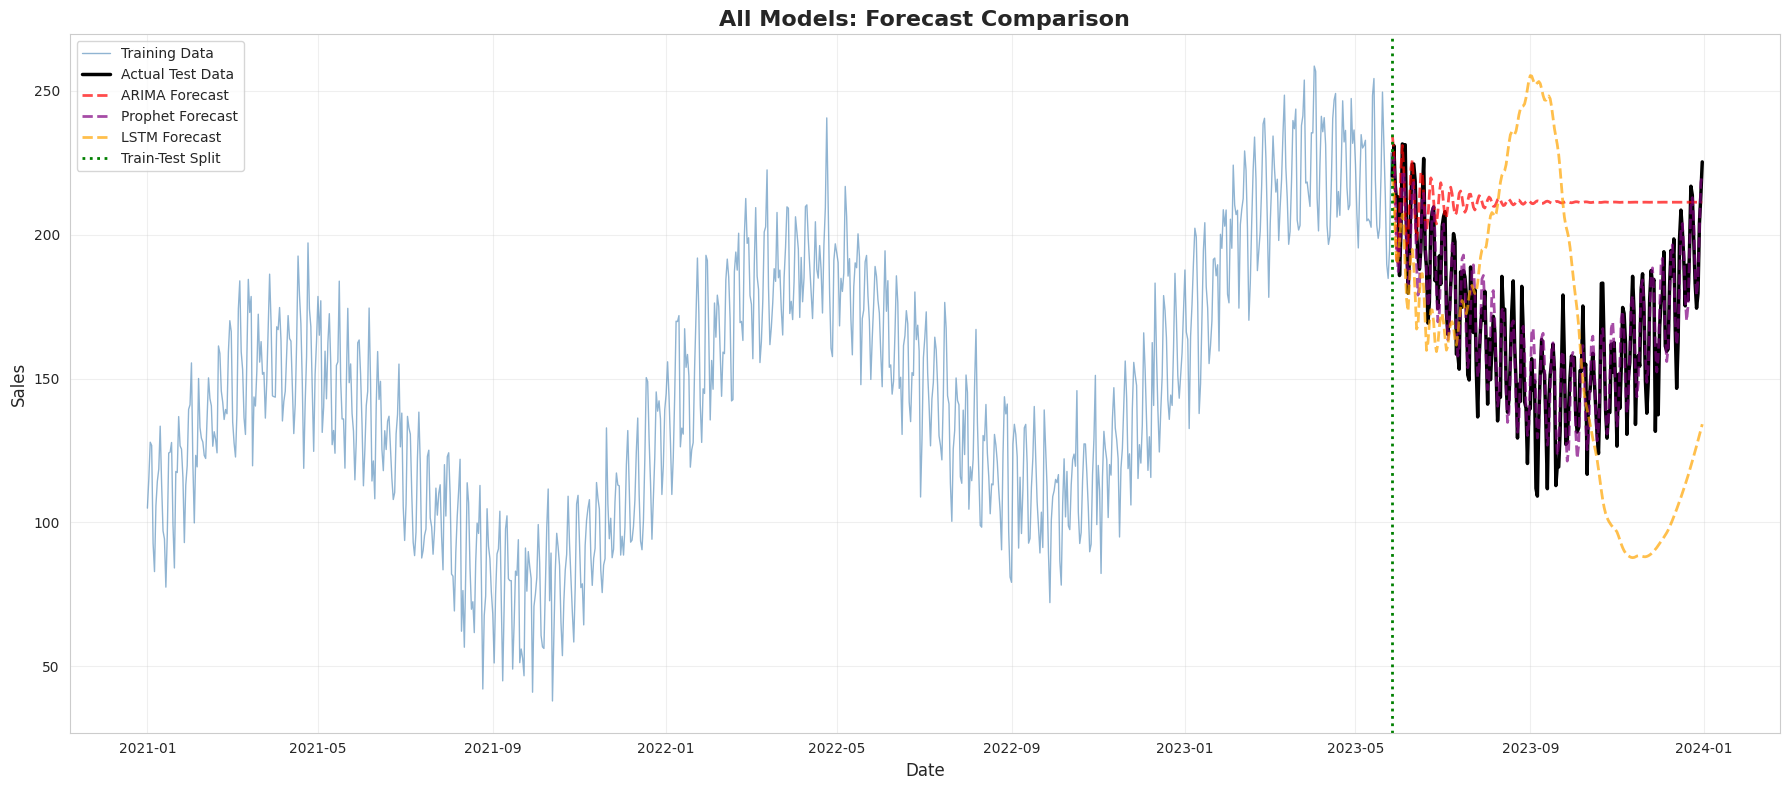

 Visualization created!


In [15]:
print("\n" + "="*60)
print("COMBINED FORECAST VISUALIZATION")
print("="*60)

# Create comprehensive visualization
plt.figure(figsize=(18, 8))

# Plot training data
plt.plot(train_df['date'], train_df['sales'], label='Training Data',
         color='steelblue', alpha=0.6, linewidth=1)

# Plot actual test data
plt.plot(test_df['date'], test_df['sales'], label='Actual Test Data',
         color='black', linewidth=2.5)

# Plot all forecasts
plt.plot(test_df['date'], arima_forecast, label='ARIMA Forecast',
         color='red', linestyle='--', linewidth=2, alpha=0.7)
plt.plot(test_df['date'], prophet_predictions, label='Prophet Forecast',
         color='purple', linestyle='--', linewidth=2, alpha=0.7)
plt.plot(test_df['date'], lstm_predictions, label='LSTM Forecast',
         color='orange', linestyle='--', linewidth=2, alpha=0.7)

# Add split line
plt.axvline(x=test_df['date'].iloc[0], color='green', linestyle=':',
            linewidth=2, label='Train-Test Split')

plt.title('All Models: Forecast Comparison', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Sales', fontsize=12)
plt.legend(loc='upper left', fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(" Visualization created!")



In [16]:
print("\n" + "="*60)
print("INTERACTIVE PLOTLY DASHBOARD")
print("="*60)

# Create interactive plot with Plotly
fig = go.Figure()

# Add training data
fig.add_trace(go.Scatter(
    x=train_df['date'],
    y=train_df['sales'],
    mode='lines',
    name='Training Data',
    line=dict(color='steelblue', width=1),
    opacity=0.6
))

# Add actual test data
fig.add_trace(go.Scatter(
    x=test_df['date'],
    y=test_df['sales'],
    mode='lines',
    name='Actual Test Data',
    line=dict(color='black', width=3)
))

# Add ARIMA forecast
fig.add_trace(go.Scatter(
    x=test_df['date'],
    y=arima_forecast,
    mode='lines',
    name=f'ARIMA (RMSE: {arima_rmse:.2f})',
    line=dict(color='red', width=2, dash='dash')
))

# Add Prophet forecast
fig.add_trace(go.Scatter(
    x=test_df['date'],
    y=prophet_predictions,
    mode='lines',
    name=f'Prophet (RMSE: {prophet_rmse:.2f})',
    line=dict(color='purple', width=2, dash='dash')
))

# Add LSTM forecast
fig.add_trace(go.Scatter(
    x=test_df['date'],
    y=lstm_predictions,
    mode='lines',
    name=f'LSTM (RMSE: {lstm_rmse:.2f})',
    line=dict(color='orange', width=2, dash='dash')
))

# Update layout
fig.update_layout(
    title='Interactive Time Series Forecasting Dashboard',
    xaxis_title='Date',
    yaxis_title='Sales',
    hovermode='x unified',
    height=600,
    template='plotly_white'
)

fig.show()

print(" Interactive dashboard created!")



INTERACTIVE PLOTLY DASHBOARD


 Interactive dashboard created!


In [17]:
print("\n" + "="*60)
print("SAVING RESULTS")
print("="*60)

# Save forecast data
forecast_results = test_df[['date', 'sales']].copy()
forecast_results.columns = ['date', 'actual']
forecast_results['arima_forecast'] = arima_forecast
forecast_results['prophet_forecast'] = prophet_predictions
forecast_results['lstm_forecast'] = lstm_predictions

forecast_results.to_csv('time_series_forecasts.csv', index=False)
print(" Forecasts saved to: time_series_forecasts.csv")

# Save model comparison
comparison_df.to_csv('model_comparison.csv', index=False)
print(" Model comparison saved to: model_comparison.csv")

# Save original data
df.to_csv('sales_data.csv', index=False)
print(" Sales data saved to: sales_data.csv")

print("\n Files created:")
print("   • time_series_forecasts.csv")
print("   • model_comparison.csv")
print("   • sales_data.csv")



SAVING RESULTS
 Forecasts saved to: time_series_forecasts.csv
 Model comparison saved to: model_comparison.csv
 Sales data saved to: sales_data.csv

 Files created:
   • time_series_forecasts.csv
   • model_comparison.csv
   • sales_data.csv


In [18]:
print("\n" + "="*60)
print("PROJECT SUMMARY REPORT")
print("="*60)

summary_report = f"""
 TIME SERIES FORECASTING PROJECT - SUMMARY
{'='*60}

1️ DATASET
   • Time Period: {df['date'].min().date()} to {df['date'].max().date()}
   • Total Days: {len(df):,}
   • Training Days: {len(train_df):,}
   • Test Days: {len(test_df):,}
   • Average Daily Sales: ${df['sales'].mean():.2f}

2️ MODELS IMPLEMENTED
   ✓ ARIMA (5,1,0)
   ✓ Facebook Prophet
   ✓ LSTM Neural Network

3️ MODEL PERFORMANCE

   ARIMA:
   • RMSE: {arima_rmse:.2f}
   • MAE: {arima_mae:.2f}
   • R²: {arima_r2:.4f}

   Prophet:
   • RMSE: {prophet_rmse:.2f}
   • MAE: {prophet_mae:.2f}
   • R²: {prophet_r2:.4f}

   LSTM:
   • RMSE: {lstm_rmse:.2f}
   • MAE: {lstm_mae:.2f}
   • R²: {lstm_r2:.4f}

4️ BEST MODEL
    {best_model}
   • Achieved lowest RMSE of {comparison_df['RMSE'].min():.2f}
   • MAE: {comparison_df.iloc[best_model_idx]['MAE']:.2f}
   • R² Score: {comparison_df.iloc[best_model_idx]['R² Score']:.4f}

5️ KEY INSIGHTS
   • Time series shows clear trend and seasonality
   • Weekly patterns detected (higher weekend sales)
   • Yearly seasonality present
   • All models capture general trends well
   • {'LSTM' if lstm_rmse < min(arima_rmse, prophet_rmse) else 'Prophet' if prophet_rmse < arima_rmse else 'ARIMA'} performed best on test data

6️ SKILLS DEMONSTRATED
   ✓ Time series analysis and decomposition
   ✓ Stationarity testing (ADF test)
   ✓ Classical forecasting (ARIMA)
   ✓ Modern ML forecasting (Prophet)
   ✓ Deep learning for time series (LSTM)
   ✓ Model evaluation and comparison
   ✓ Interactive visualization

7️ BUSINESS APPLICATIONS
   • Inventory planning and optimization
   • Revenue forecasting
   • Demand prediction
   • Resource allocation
   • Budget planning

{'='*60}
 PROJECT COMPLETED SUCCESSFULLY!
Date: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}
"""

print(summary_report)

# Save report
with open('project_summary.txt', 'w') as f:
    f.write(summary_report)

print("\n Summary report saved to: project_summary.txt")

print("\n" + "="*60)
print(" MINI PROJECT 4 COMPLETED!")
print("="*60)
print("\n Next steps:")
print("   1. Download all files from Colab Files panel")
print("   2. Download this notebook (.ipynb)")
print("   3. Upload to GitHub")
print("\n You've successfully completed a comprehensive time series forecasting project!")



PROJECT SUMMARY REPORT

 TIME SERIES FORECASTING PROJECT - SUMMARY

1️ DATASET
   • Time Period: 2021-01-01 to 2023-12-31
   • Total Days: 1,095
   • Training Days: 876
   • Test Days: 219
   • Average Daily Sales: $150.36

2️ MODELS IMPLEMENTED
   ✓ ARIMA (5,1,0)
   ✓ Facebook Prophet
   ✓ LSTM Neural Network

3️ MODEL PERFORMANCE

   ARIMA:
   • RMSE: 51.32
   • MAE: 44.95
   • R²: -2.5358
   
   Prophet:
   • RMSE: 9.85
   • MAE: 7.80
   • R²: 0.8699
   
   LSTM:
   • RMSE: 63.65
   • MAE: 53.83
   • R²: -4.4382

4️ BEST MODEL
    Prophet
   • Achieved lowest RMSE of 9.85
   • MAE: 7.80
   • R² Score: 0.8699

5️ KEY INSIGHTS
   • Time series shows clear trend and seasonality
   • Weekly patterns detected (higher weekend sales)
   • Yearly seasonality present
   • All models capture general trends well
   • Prophet performed best on test data

6️ SKILLS DEMONSTRATED
   ✓ Time series analysis and decomposition
   ✓ Stationarity testing (ADF test)
   ✓ Classical forecasting (ARIMA)
  